<h1>A DCGAN model to generate fake monet pictures</h1>

<p><b>Author:</b> Sebastian Gomez Ahumada</p>

<p>A DCGAN model is a specific DL model composed of a generator and a discriminator, the generator generates fakes images and the discriminator must to classify the images between real or fake (binary classification), both models are trained simultaneously and their weights are updated at the same time (they learn at the same time).</p>

<p>In this notebook, we are going to train a DCGAN model that generates fake Monet pictures based on the Kaggle competition <i><b>I´m something of a painter myself.</b></i></p>

<h2>Dataset description</h2>

In [1]:
import tensorflow_datasets as tfds
data, data_info = tfds.load('cycle_gan/monet2photo', download=True, with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1072 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteP7DRH5/cycle_gan-trainA.tfrecord*...…

Generating trainB examples...:   0%|          | 0/6287 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteP7DRH5/cycle_gan-trainB.tfrecord*...…

Generating testA examples...:   0%|          | 0/121 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteP7DRH5/cycle_gan-testA.tfrecord*...:…

Generating testB examples...:   0%|          | 0/751 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteP7DRH5/cycle_gan-testB.tfrecord*...:…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


In [2]:
import glob, os
import matplotlib.pyplot as plt

In [3]:
print(data.keys())

dict_keys(['trainA', 'trainB', 'testA', 'testB'])


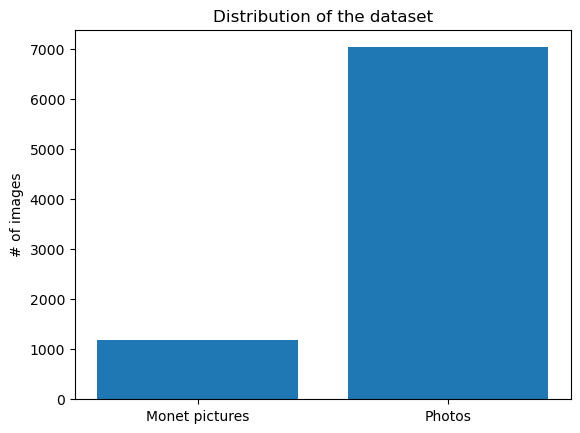

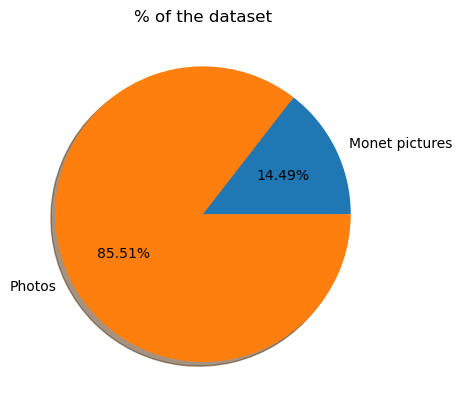

In [4]:
plt.figure()
plt.bar(["Monet pictures", "Photos"],[len(data["trainA"]) + len(data["testA"]),len(data["trainB"]) + len(data["testB"])])
plt.title("Distribution of the dataset")
plt.ylabel("# of images")
plt.show()

plt.figure()
plt.pie([len(data["trainA"]) + len(data["testA"]),len(data["trainB"]) + len(data["testB"])],labels=["Monet pictures", "Photos"],
        autopct=lambda p:'{:.2f}%'.format(p),shadow=True)
plt.title("% of the dataset")
plt.show()

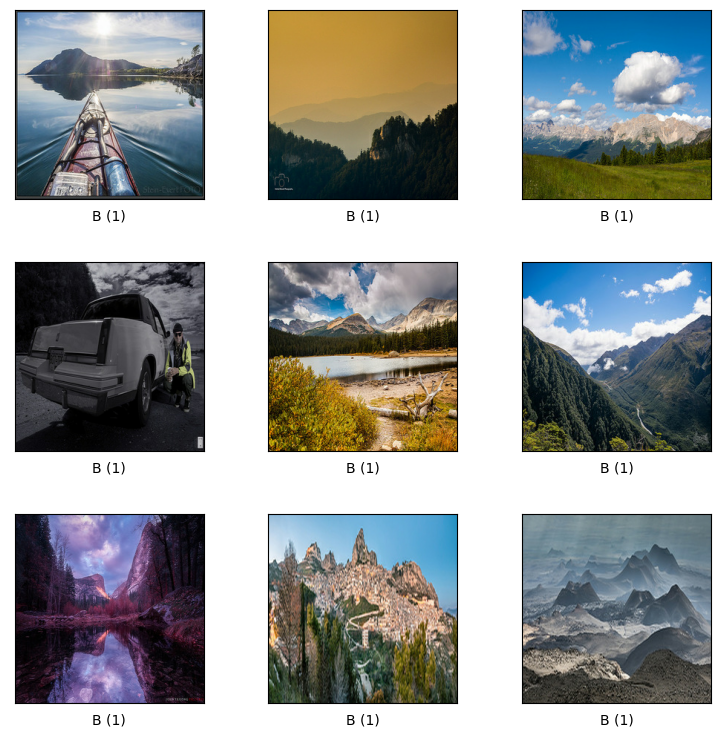

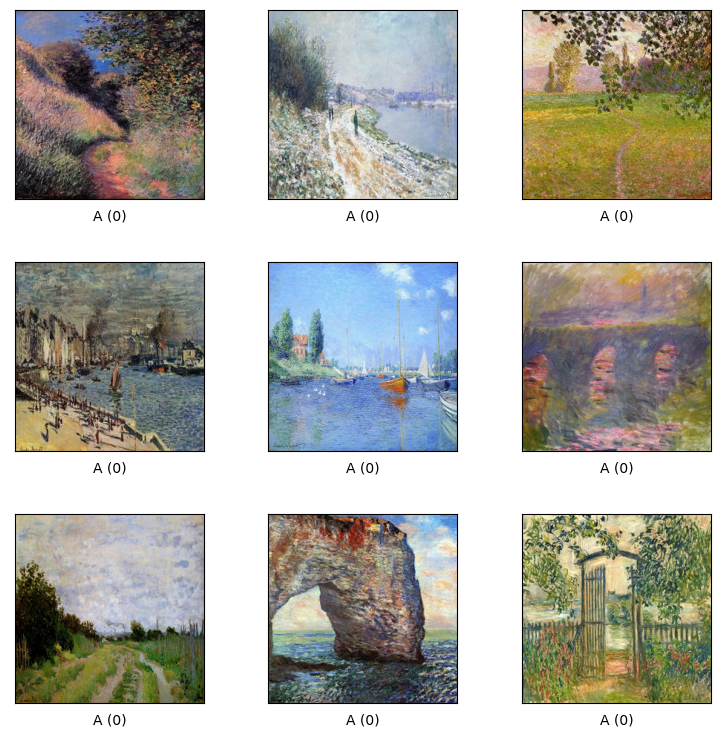

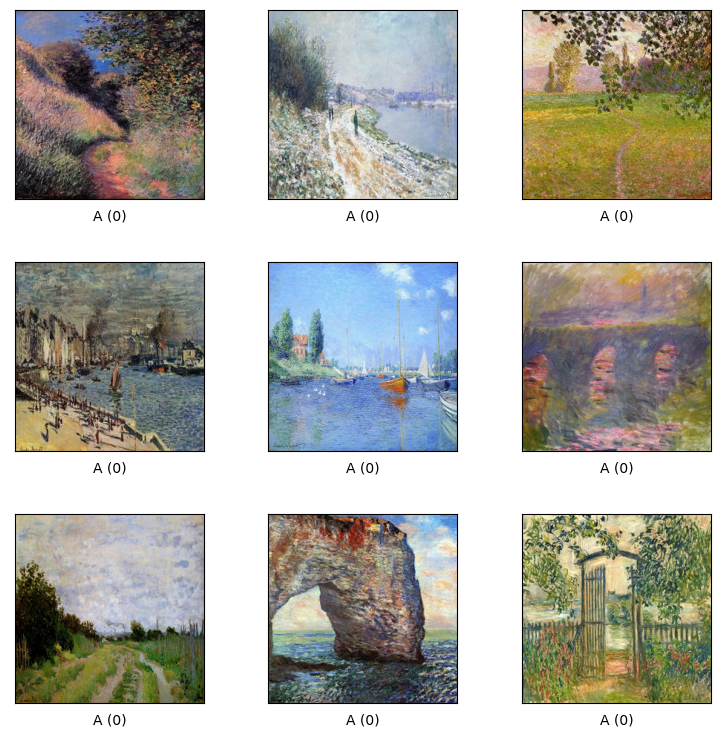

In [5]:
tfds.visualization.show_examples(data['trainB'],data_info)
tfds.visualization.show_examples(data['trainA'],data_info)

<h2>Model definition</h2>

In [6]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1


In [7]:
import keras 
! pip install visualkeras
import visualkeras
from keras.layers import Dense, Conv2DTranspose, Dropout, LeakyReLU, Reshape,BatchNormalization, Conv2D, Flatten

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 13.4 MB/s eta 0:00:00


In [8]:
def generator_model():
    model = keras.Sequential(name="Generator_V1")
    model.add(Dense(2*2*1024,use_bias=False, input_shape = (100,)))
    model.add(Reshape((2,2,1024)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(512,(3,3),(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Conv2DTranspose(256,(3,3),(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Conv2DTranspose(128,(3,3),(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Conv2DTranspose(64,(3,3),(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Conv2DTranspose(32,(3,3),(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Conv2DTranspose(16,(3,3),(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Conv2DTranspose(8,(3,3),(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Conv2DTranspose(3,(3,3),(1,1),padding="same",activation="tanh"))

    return model

In [9]:
import tensorflow as tf

strategy = tf.distribute.get_strategy()

with strategy.scope():
    generator = generator_model()

generator.summary()

Model: "Generator_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              409600    
                                                                 
 reshape (Reshape)           (None, 2, 2, 1024)        0         
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 1024)       4096      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2, 2, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        4719104   
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4, 4, 512)        

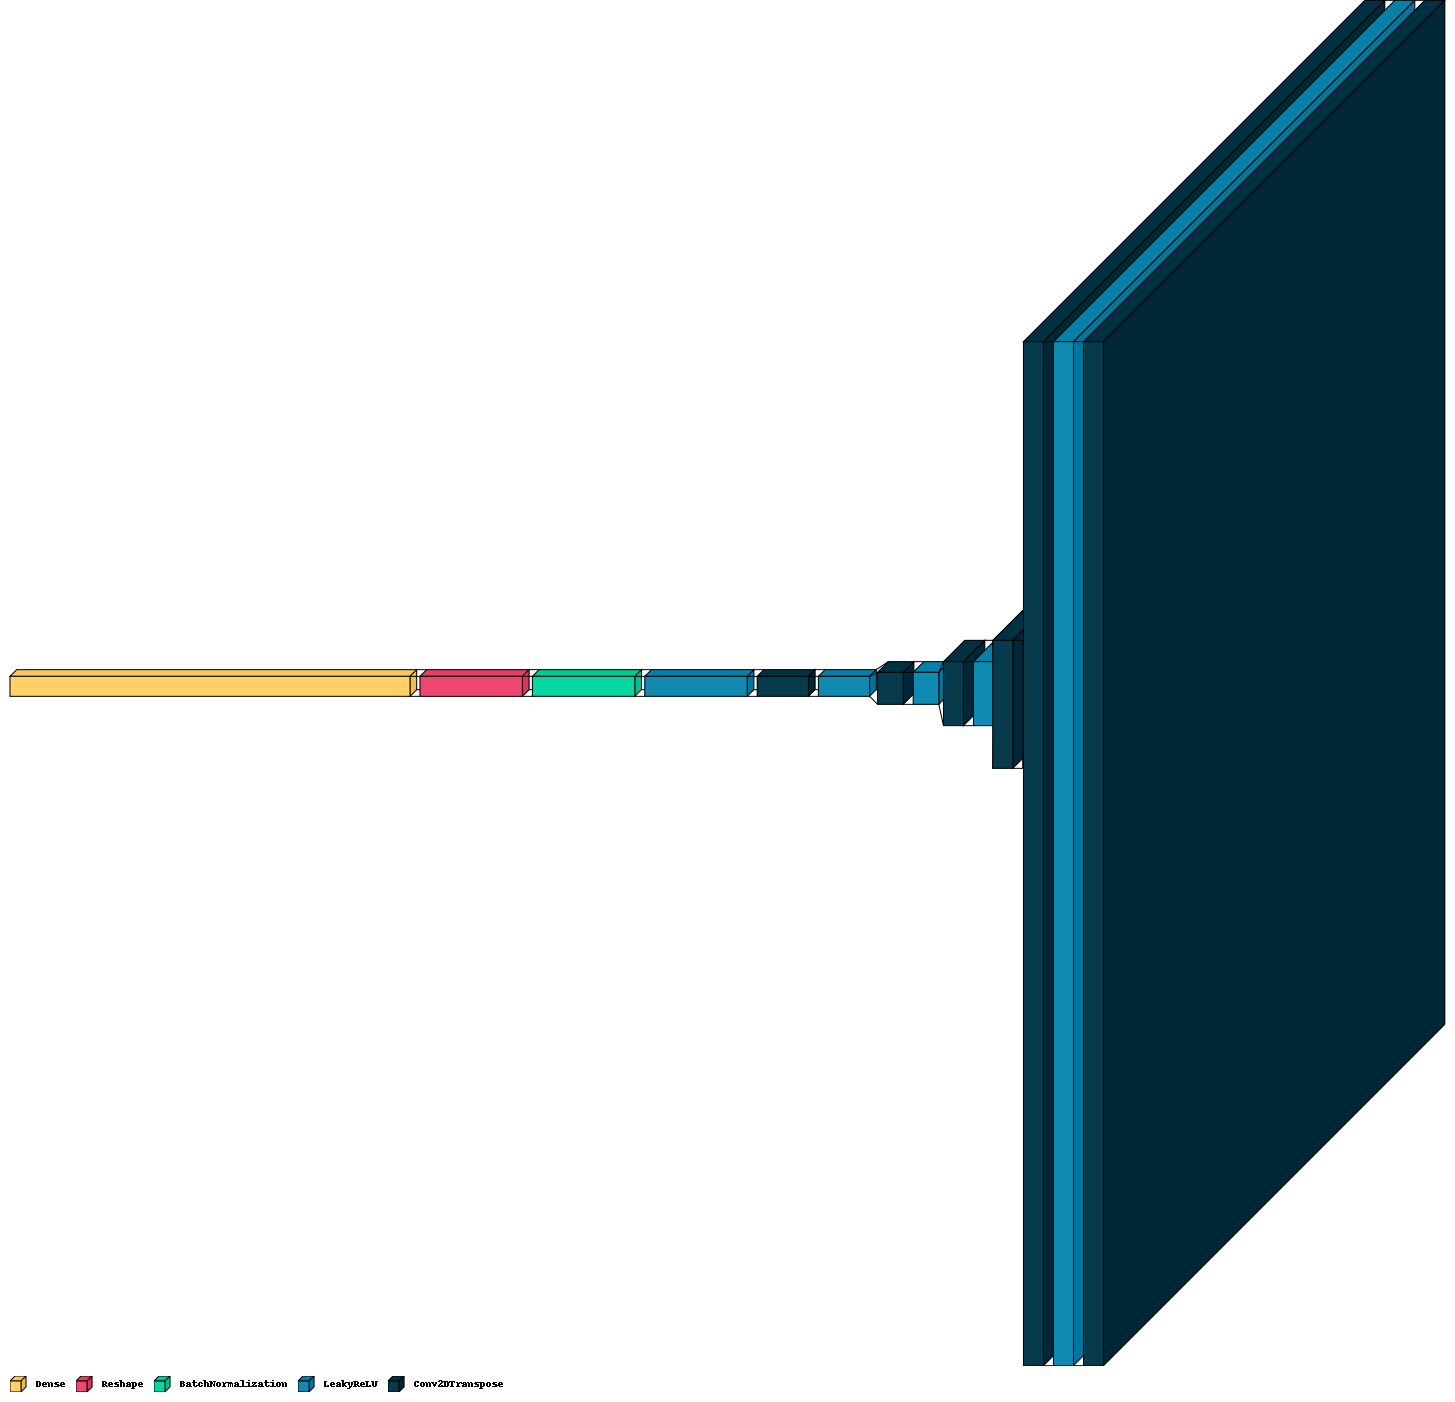

In [10]:
visualkeras.layered_view(generator,legend=True)

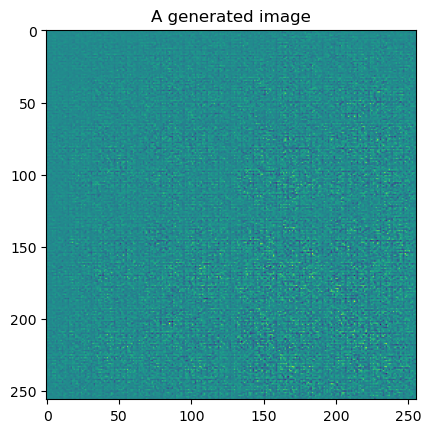

In [11]:
noise = tf.random.normal([1,100])
with strategy.scope():
    generated = generator(noise, training= False)

plt.figure()
plt.title("A generated image")
plt.imshow(generated[0,:,:,0])
plt.show()

In [12]:
def discriminator_model():
    model = keras.Sequential()
    model.add(Conv2D(8,(3,3),(2,2),padding="same",input_shape = (256,256,3)))
    model.add(LeakyReLU())
    
    model.add(Conv2D(16,(3,3),(2,2),padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(32,(3,3),(2,2),padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64,(3,3),(2,2),padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(128,(3,3),(2,2),padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(256,(3,3),(2,2),padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(512,(3,3),(2,2),padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(1024,(3,3),(2,2),padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    return model

In [13]:
with strategy.scope():
    discriminator = discriminator_model()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128, 128, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                        

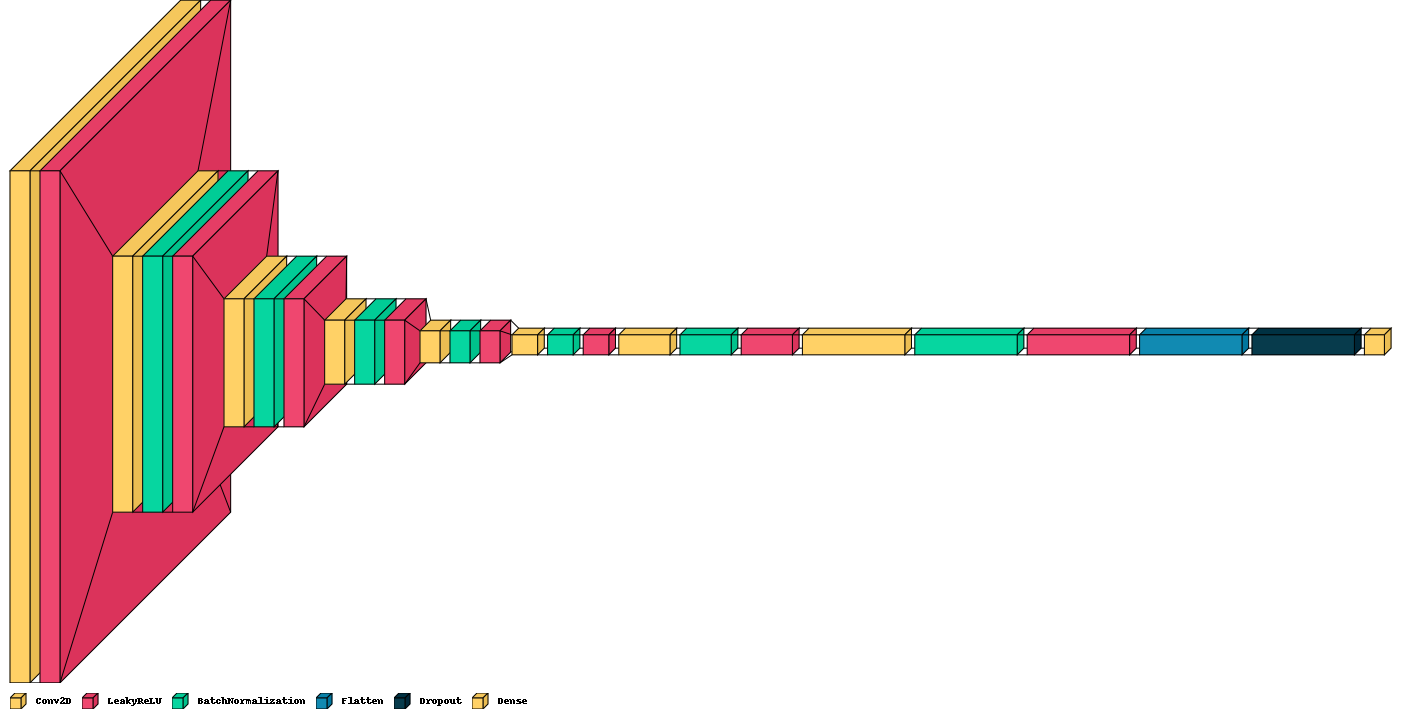

In [14]:
visualkeras.layered_view(discriminator,legend=True)

In [15]:
with strategy.scope():
    rate = discriminator(generated)
print(f"Decision: {rate}")

Decision: [[0.5000003]]


In [16]:
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

with strategy.scope():
    def generator_loss(output):
        metric = BinaryCrossentropy()
        return metric(tf.ones_like(output),output)
    
    def discriminator_loss(real_output,fake_output):
        metric = BinaryCrossentropy()
        real_loss = metric(tf.ones_like(real_output),real_output)
        fake_loss = metric(tf.zeros_like(fake_output),fake_output)
        return real_loss + fake_loss
    gen_optimizer = Adam()
    dis_optimizer = Adam()


In [17]:
epochs = 30
batch_size = 32
fake_gen_dim = 100
shape_dim = (256,256,3)

In [18]:
import time
import pandas as pd
from skimage.io import imsave
import numpy as np

class MY_DCGAN:
    def __init__(self, gen_dim, epochs, batch_size, generator, discriminator, dataset):
        self.gen_dim = gen_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = generator
        self.discriminator = discriminator
        self.dataset = dataset
    
    @tf.function

    def train(self, images):

        fake_vector = tf.random.normal([images.shape[0], self.gen_dim])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            fake_imgs = self.generator(fake_vector,training = True)

            real_out = discriminator(images, training = True)
            fake_out = discriminator(fake_imgs, training=True)

            gen_loss = generator_loss(fake_out)
            disc_loss = discriminator_loss(real_out,fake_out)

            gen_gradient = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_gradient = dis_tape.gradient(disc_loss, self.discriminator.trainable_variables) 

            gen_optimizer.apply_gradients(zip(gen_gradient,self.generator.trainable_variables))
            dis_optimizer.apply_gradients(zip(disc_gradient, self.discriminator.trainable_variables))

            return (gen_loss + disc_loss)/2
    
    @tf.function
    def distributed_train(self, images):
        losses = strategy.run(self.train, args = (images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, losses, axis=None)
    
    def generate_images(self):
        noise = tf.random.normal([self.batch_size, self.gen_dim])
        predictions = self.generator.predict(noise)
        return predictions
    
    def generate_and_export(self,n_images):
        ! mkdir ../images
        for i in range(n_images):
            noise = tf.random.normal([1,self.gen_dim])
            image = self.generator.predict(noise).reshape(shape_dim)
            imsave("../images/" + f"imagen_{i+1}.jpg",(image*127.5 + 127.5).astype(np.uint8),format = "jpg")
        print(f"Generadas {n_images} imagenes de 256x256")


    def plot_fake_imgs(self):
        images = self.generate_images()
        plt.figure()
        for i in range(12):
            plt.imshow(images[i,:,:,0])
            plt.axis("off")
        plt.show()
        
    
    def train_loop(self):
        epoch_list = []
        loss_list = []
        for epoch in range(self.epochs):
            init_time = time.time()

            total_loss = 0.0
            n_batches = 0

            for each_batch in self.dataset:
                loss = self.distributed_train(each_batch["image"])
                total_loss+= tf.reduce_mean(loss)
                n_batches += 1
            mean_loss = total_loss/n_batches

            epoch_list.append(epoch+1)
            loss_list.append(mean_loss)

            print(f"Epoch: {epoch+1} - Time: {time.time() - init_time} - Loss: {mean_loss}")
                
            if (epoch+1) % 10 == 0:
                self.plot_fake_imgs()
        return pd.DataFrame({"Epoch":epoch_list,"Loss":loss_list})


In [19]:
from keras.utils import image_dataset_from_directory

print(os.curdir)

monet_ds = tfds.as_numpy(data["trainA"].batch(32))
photo_ds = tfds.as_numpy(data["trainB"].batch(32))

.


Epoch: 1 - Time: 109.54486513137817 - Loss: 1.6440414190292358
Epoch: 2 - Time: 103.74025702476501 - Loss: 1.0649755001068115
Epoch: 3 - Time: 102.37870597839355 - Loss: 1.0440205335617065
Epoch: 4 - Time: 101.20654392242432 - Loss: 1.0562571287155151
Epoch: 5 - Time: 102.79563617706299 - Loss: 1.0864269733428955
Epoch: 6 - Time: 103.50949835777283 - Loss: 1.087034821510315
Epoch: 7 - Time: 103.97260808944702 - Loss: 1.0875420570373535
Epoch: 8 - Time: 104.38937044143677 - Loss: 1.06863272190094
Epoch: 9 - Time: 104.15577745437622 - Loss: 1.1563109159469604
Epoch: 10 - Time: 103.11115050315857 - Loss: 1.2015364170074463
1/1 [==============================] - 1s 1s/step


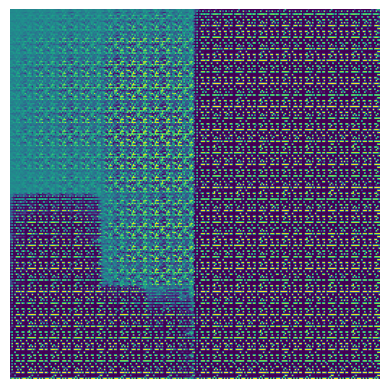

Epoch: 11 - Time: 104.16088080406189 - Loss: 1.2869120836257935
Epoch: 12 - Time: 103.86989307403564 - Loss: 1.2159144878387451
Epoch: 13 - Time: 102.87495803833008 - Loss: 1.291577696800232
Epoch: 14 - Time: 103.147465467453 - Loss: 1.240736484527588
Epoch: 15 - Time: 103.298996925354 - Loss: 1.3742018938064575
Epoch: 16 - Time: 103.9010238647461 - Loss: 1.4879281520843506
Epoch: 17 - Time: 103.59112811088562 - Loss: 1.6050000190734863
Epoch: 18 - Time: 103.47909617424011 - Loss: 1.6095834970474243
Epoch: 19 - Time: 104.02211809158325 - Loss: 1.587769627571106
Epoch: 20 - Time: 103.20219898223877 - Loss: 1.7634265422821045
1/1 [==============================] - 1s 1s/step


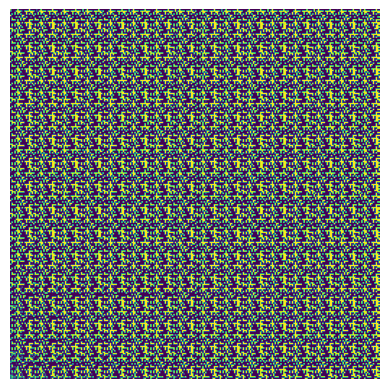

Epoch: 21 - Time: 103.3264467716217 - Loss: 1.940807819366455
Epoch: 22 - Time: 104.02291941642761 - Loss: 2.042178153991699
Epoch: 23 - Time: 104.2131974697113 - Loss: 2.2135748863220215
Epoch: 24 - Time: 103.96306085586548 - Loss: 2.18361759185791
Epoch: 25 - Time: 103.4670774936676 - Loss: 2.118455410003662
Epoch: 26 - Time: 103.39284610748291 - Loss: 2.4303815364837646
Epoch: 27 - Time: 103.27032423019409 - Loss: 2.350515842437744
Epoch: 28 - Time: 103.20850968360901 - Loss: 2.0741217136383057
Epoch: 29 - Time: 103.18213319778442 - Loss: 1.947901964187622
Epoch: 30 - Time: 104.58474349975586 - Loss: 2.3971316814422607
1/1 [==============================] - 1s 1s/step


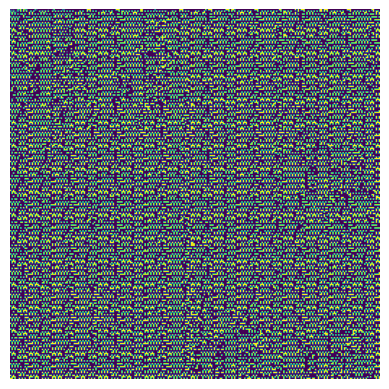

In [20]:
gan_model = MY_DCGAN(fake_gen_dim,epochs,batch_size,generator,discriminator,monet_ds)
results = gan_model.train_loop()

In [21]:
results["Loss"] = [i.numpy() for i in results["Loss"]]

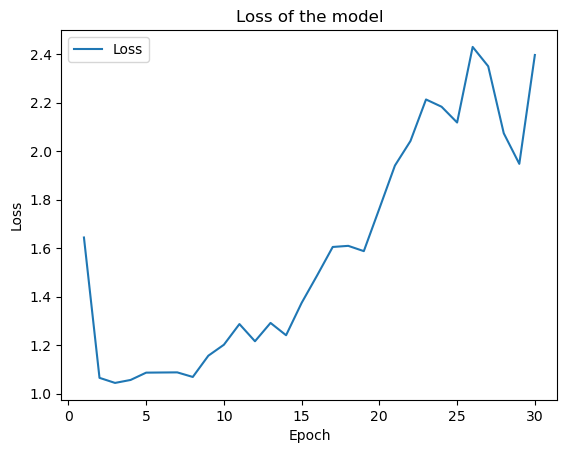

In [22]:
results.plot.line("Epoch","Loss")
plt.ylabel("Loss")
plt.title("Loss of the model")
plt.show()

In [23]:
gan_model.generate_and_export(8000)
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

1/1 [==============================] - 0s 66ms/step
Generadas 8000 imagenes de 256x256


'/kaggle/working/images.zip'